# 神经网络的反向传播算法

（这一节反向传播的代码理解得不好）

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
data = sio.loadmat('ex4data1.mat')
raw_X = data['X']
raw_y = data['y']

In [3]:
X = np.insert(raw_X, 0, values=1, axis=1)
X, X.shape

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 (5000, 401))

**对 y 进行 one-hot 编码处理**

本来 y 是1~10的数字，将 y 编码成由10个0或1组成的向量，1的索引表示 y 的值。

In [4]:
def one_hot_encoder(raw_y):
    result = []
    for i in raw_y:
        y_temp = np.zeros(10)
        y_temp[i-1] = 1         # y:1~10, index:0~9
        
        result.append(y_temp)
        
    return np.array(result)

In [5]:
y = one_hot_encoder(raw_y)

In [6]:
raw_y, y

(array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8),
 array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]]))

**权重**

In [7]:
theta = sio.loadmat('ex4weights.mat')
theta

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Oct 18 14:57:02 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Theta1': array([[-2.25623899e-02, -1.05624163e-08,  2.19414684e-09, ...,
         -1.30529929e-05, -5.04175101e-06,  2.80464449e-09],
        [-9.83811294e-02,  7.66168682e-09, -9.75873689e-09, ...,
         -5.60134007e-05,  2.00940969e-07,  3.54422854e-09],
        [ 1.16156052e-01, -8.77654466e-09,  8.16037764e-09, ...,
         -1.20951657e-04, -2.33669661e-06, -7.50668099e-09],
        ...,
        [-1.83220638e-01, -8.89272060e-09, -9.81968100e-09, ...,
          2.35311186e-05, -3.25484493e-06,  9.02499060e-09],
        [-7.02096331e-01,  3.05178374e-10,  2.56061008e-09, ...,
         -8.61759744e-04,  9.43449909e-05,  3.83761998e-09],
        [-3.50933229e-01,  8.85876862e-09, -6.57515140e-10, ...,
         -1.80365926e-06, -8.14464807e-06,  8.79454531e-09]]),
 'Theta2': array([[-0.76100352, -1.21244498, -0.10187131, -2.36850085, -1.057781

In [8]:
theta1, theta2 = theta['Theta1'], theta['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

### 2 序列化theta

In [9]:
def serialize(a, b):
    return np.append(a.flatten(), b.flatten())

In [10]:
theta_serialize = serialize(theta1, theta2)

In [11]:
theta_serialize.shape

(10285,)

### 3 解序列化

In [12]:
def deserialize(theta_serialize):
    theta1 = theta_serialize[:25*401].reshape(25, 401)
    theta2 = theta_serialize[25*401:].reshape(10, 26)
    return theta1, theta2

In [13]:
theta1, theta2 = deserialize(theta_serialize)

In [14]:
theta1.shape, theta2.shape

((25, 401), (10, 26))

### 4 前向传播

In [15]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [16]:
def feed_forward(theta_serialize, X):
    theta1, theta2 = deserialize(theta_serialize)
    
    a1 = X        # (5000, 401)
    
    z2 = a1 @ theta1.T   # (5000, 401) @ (401, 25)  ==>  (5000, 25)
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, values=1, axis=1)  # (5000, 26)
    
    z3 = a2 @ theta2.T   # (5000, 26) @ (26, 10)  ==>  (5000, 10)
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h  # 反向传播会用到    

### 5 损失函数

1. 无正则化项的损失函数：
$$
J(\Theta) = -\frac{1}{m}\bigg[\sum_{i=1}^{m}\sum_{k=1}^{K}y^{(i)}_k \log (h_\Theta(x^{(i)}))_k+(1-y^{(i)}_k) \log(1-h_\Theta(x^{(i)}))_k\bigg] \\
$$
向量化：
$$
J = -\frac{1}{m}*np.sum(y*np.log(h) + (1-y)*np.log(1-h))
$$

2. 有正则化项的损失函数：
$$
J(\Theta) = -\frac{1}{m}\bigg[\sum_{i=1}^{m}\sum_{k=1}^{K}y^{(i)}_k \log (h_\Theta(x^{(i)}))_k+(1-y^{(i)}_k) \log(1-h_\Theta(x^{(i)}))_k\bigg] \\
+ \frac{\lambda}{2m}\bigg[  \sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta^{(1)}_{j, k})^2 + \sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta^{(2)}_{j, k})^2    \bigg]
$$
向量化：
```
reg = lambda / (2*m)*[np.sum(theta1[:, 1:]**2) + np.sum(theta2[:,1:]**2)]
```
**偏置项（第一列）不做正则化**


#### 5.1 不带正则化的损失函数

In [17]:
def cost(theta_serialize, X, y):
    a1, z2, a2, z3, h = feed_forward(theta_serialize, X)  # 进行前向传播
    J = -np.sum(y*np.log(h) + (1-y)*np.log(1-h)) / len(X)
    return J

In [18]:
cost(theta_serialize, X, y)

0.2876291651613189

#### 5.2 带正则化的损失函数

In [19]:
def reg_cost(theta_serialize, X, y, _lambda):
    sum1 = np.sum(np.power(theta1[:, 1:], 2))
    sum2 = np.sum(np.power(theta2[:, 1:], 2))
    reg = (sum1 + sum2) * _lambda / (2 * len(X))
    return cost(theta_serialize, X, y) + reg

In [20]:
_lambda = 1
reg_cost(theta_serialize, X, y, _lambda)

0.38376985909092365

### 6 反向传播

#### 6.1 无正则化的梯度

$
\frac{\partial}{\partial\theta^{(2)}}J(\theta) = \frac{\partial}{\partial a^{(3)}}\frac{\partial a^{(3)}}{\partial z^{(3)}}\frac{\partial z^{(3)}}{\partial \theta^{(3)}} = (h-y)a^{(2)} = d^{(3)}a^{(2)}
$
$
\frac{\partial}{\partial\theta^{(1)}}J(\theta) = \frac{\partial}{\partial a^{(3)}}\frac{\partial a^{(3)}}{\partial z^{(3)}}\frac{\partial z^{(3)}}{\partial a^{(2)}}\frac{\partial a^{(2)}}{\partial z^{(2)}}\frac{\partial z^{(2)}}{\partial \theta^{(1)}} =(h-y)\theta^{(2)} g'(z^{(2)})a^{(1)}= d^{(2)}a^{(1)}
$
$sigmoid(z)' = sigmoid(z)*(1-sigmoid(z))$

In [21]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1-sigmoid(z))

In [22]:
def gradient(theta_serialize, X, y):
    theta1, theta2 = deserialize(theta_serialize)
    a1, z2, a2, z3, h = feed_forward(theta_serialize, X)
    
    d3 = h - y   # (5000, 10)
    d2 = d3 @ theta2[:, 1:] * sigmoid_gradient(z2)   # (5000, 10) @ (10, 26-1) * (5000, 25) ==>  (5000, 25)
    
    D2 = (d3.T @ a2) / len(X)   # J 对 theta2 的梯度, (10, 5000) @ (5000, 25) ==> (10, 25)
    D1 = (d2.T @ a1) / len(X)   # J 对 theta1 的梯度, (25, 5000) @ (5000, 400) ==> (25, 400)
    
    return serialize(D1, D2)

#### 6.2 带正则化的梯度

```
reg1 = (lambda/m) * theta1[:, 1:]
reg2 = (lambda/m) * theta2[:, 1:]
```

In [23]:
def reg_gradient(theta_serialize, X, y, _lambda):
    D = gradient(theta_serialize, X, y)
    D1, D2 = deserialize(D)
    
    theta1, theta2 = deserialize(theta_serialize)
    D1[:, 1:] = D1[:, 1:] + theta1[:, 1:] * _lambda / len(X)
    D2[:, 1:] = D2[:, 1:] + theta2[:, 1:] * _lambda / len(X)
    
    return serialize(D1, D2)

#### 7 神经网络的优化（梯度下降）

In [24]:
from scipy.optimize import minimize

def nn_training(X, y):
    init_theta = np.random.uniform(-0.5, 0.5, 10285)
    res = minimize(fun = cost, 
                  x0 = init_theta, 
                  args = (X, y), 
                  method = 'TNC', 
                  jac = gradient, 
                  options = {'maxiter':300})
    
    return res

In [25]:
res = nn_training(X, y)

C:\Users\asus\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\asus\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
raw_y = data['y'].reshape(5000, )

In [27]:
_, _, _, _, h = feed_forward(res.x, X)  # res.x 是 theta_serialize
y_predict = np.argmax(h, axis=1) + 1
acc = np.mean(y_predict == raw_y)

In [28]:
acc

0.9884

In [29]:
res.x

array([-1.21304281,  0.35723917, -0.29778302, ...,  3.15768665,
        2.24545377, -1.35929403])

由于没加正则项，出现了过拟合。

In [30]:
def nn_training_reg(X, y):
    init_theta = np.random.uniform(-0.5, 0.5, 10285)
    res = minimize(fun = reg_cost, 
                  x0 = init_theta, 
                  args = (X, y, _lambda), 
                  method = 'TNC', 
                  jac = reg_gradient, 
                  options = {'maxiter':300})
    
    return res

In [31]:
_lambda = 10
res2 = nn_training_reg(X, y)

_, _, _, _, h2 = feed_forward(res2.x, X)  # res.x 是 theta_serialize
y_predict2 = np.argmax(h2, axis=1) + 1
acc2 = np.mean(y_predict2 == raw_y)

acc2

0.939

In [32]:
res2.x

array([-1.01877213e-01, -1.04636821e-03,  1.02855377e-04, ...,
        6.66126633e-01, -6.07209985e-01, -9.74908201e-01])

加上正则化，过拟合程度降低。theta的数值减小。

### 8 可视化隐藏层
把theta1(25, 400)显示成图片

In [33]:
def plot_hidden_layer(theta):
    theta1, _ = deserialize(theta)
    hidden_layer = theta1[:, 1:]   # (25, 400)
    
    fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(8, 8), sharex=True, sharey=True)
    
    for i in range(5):
        for j in range(5):
            ax[i, j].imshow(hidden_layer[5*i + j].reshape(20, 20).T, cmap='gray_r')
            
    plt.xticks([])
    plt.yticks([])
    
    plt.show

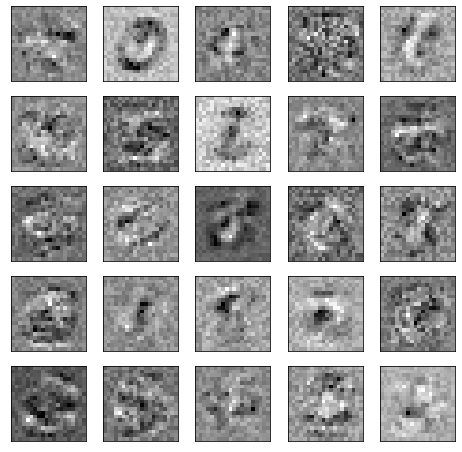

In [34]:
plot_hidden_layer(res.x)